<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/deeplearning.ai/tf/transfer_learning_and_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning and Fine Tunning

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively server as a generic model of the visual world. You can then take advantage of these leaned feature maps without having to start from scratch by training a large model on a large dataset.

Transfer learning approached contained on this notebook:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously from the dataset.

 You don't need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

2. Fine-Tunning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classfier layers and the last layers of the base model. This allow us to "fine-tune" the higher order feature representations in the base model in order to make them more relevant for the specific task.

Plan of attack:

1. Examine and understand the data
2. Build an `input pipeline`, in this case using Keras ImageDataGenerator
3. Compose the model
  - Load in the pretrained base model (and pretrained weights)
  - Stack the classfication layers on top
4. Train the model 
5. Evaluate model




In [34]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

## Data preprocessing

### Data download

We will use a dataset containing several thousand images of cats and cats. Download and extract a zip file containing the images, then create a `tf.data.Dataset` for training and validation using the `.image_dataset_from_directory` utility.

In [35]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, 
                                      extract=True)

In [36]:
print(f'path_to_zip -> {path_to_zip}')
print(f'os.path.dirname(path_to_zip) -> {os.path.dirname(path_to_zip)}')

path_to_zip -> /root/.keras/datasets/cats_and_dogs.zip
os.path.dirname(path_to_zip) -> /root/.keras/datasets


In [37]:
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

print(f'train_dir -> {train_dir}')
print(f'validation_dir -> {validation_dir}')

train_dir -> /root/.keras/datasets/cats_and_dogs_filtered/train
validation_dir -> /root/.keras/datasets/cats_and_dogs_filtered/validation


In [38]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [39]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Show the first nine images and labels from the training set:

In [40]:
class_names = train_dataset.class_names
class_names

['cats', 'dogs']

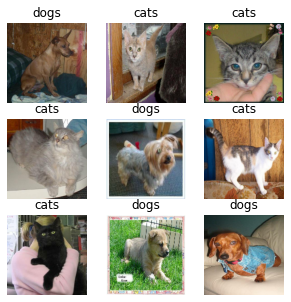

In [41]:
plt.figure(figsize=(5, 5))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

As the original dataset doesn't contain a test set, we will have to create one. To do so, determine how many batches are available in the validation set using
`tf.data.experimental.cardinality`, then move 20% of them to a test set.

In [42]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
val_batches.numpy()

32

In [43]:
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [44]:
print(f'Number of validation batches: {tf.data.experimental.cardinality(validation_dataset)}')
print(f'Number of test batches: {tf.data.experimental.cardinality(test_dataset)}')

Number of validation batches: 26
Number of test batches: 6


## Configure the dataset for performance

Use buffered prefetching to load images from dish without having I/O become blocking.

In [45]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Use data augmentation

When you don't have a large image dataset, it's good practive to articially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting.





In [46]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

Note: These layers are active only during training, when you call `model.fit`. They are inactive when the model is used in inference mode in `model.evaluate`. Let's repeatedly apply these layers to the same image and see the result.

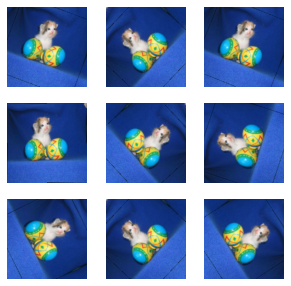

In [48]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(5, 5))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Rescale pixel values

In a moment, you will download `tf.keras.aplications.MobileNetV2` for use as your base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are `[0-255]`. To rescale them, use the preprocessing method included with the model.

In [49]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Note: Alternarively, you could rescale pixel values from `[0, 255]` to `[-1,1]` using a Rescaling Layer.

In [52]:
rescale_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1)

Note: If using other tf.keras.applications, be sure to check the API doc to determine if they expect pixels in [-1,1] or [0, 1], or use preprocess_input

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful.  Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the `bottleneck layer`. The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [53]:
IMG_SHAPE = IMG_SIZE + (3, )
IMG_SHAPE

(160, 160, 3)

In [57]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, 
                                               include_top=False, 
                                               weights='imagenet')

This featute extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images.

In [58]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
feature_batch.shape


TensorShape([32, 5, 5, 1280])

## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base **before you compile and train the model**. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [59]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial. 

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics. 

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [61]:
# base_model.summary()

## Add a classification head

To generate prediction from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to a single `1280` element vector per image.

In [62]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
feature_batch_average.shape

TensorShape([32, 1280])

Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [63]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
prediction_batch.shape

TensorShape([32, 1])

Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the keras functional api. As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [64]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


## Compile the model

Compile the model before training it. Since there are two classes, use a binary cross-entropy loss with `from_logits=True` since the model provides a linear output.

In [65]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [66]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

The 2.5M parameters in MobileNet are frozen, but there are 1.2K trainable parameters in the Dense layer. 

In [68]:
len(model.trainable_variables)

2

## Train the model 

After training for 10 epochs, you should see ~94% accuracy on the validation set.

In [69]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 14s 552ms/step - loss: 0.6705 - accuracy: 0.6176


In [70]:
print(f'initial loss: {loss0:.2f}')
print(f'initial accuracy: {accuracy0:.2f}')

initial loss: 0.67
initial accuracy: 0.62


In [71]:
history = model.fit(train_dataset, 
                    epochs=initial_epochs, 
                    validation_data=validation_dataset)

Epoch 1/10
21/63 [=========>....................] - ETA: 26s - loss: 0.6973 - accuracy: 0.6116

KeyboardInterrupt: ignored